In [155]:
import torch
import torch.nn.functional as F
import random
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [156]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# global params
batch_size = 32
max_steps = 200000

In [157]:
def build_dataset(words):
    global ctx_len
    ctx_len = 3  # context lenght: we use 3 previous character to predict next char
    X, Y = [], []
    
    for w in words:
        # print('next word:', w)
        ctx = [0] * ctx_len
        for ch in w + '.':
            ix = stoi[ch] # get int version of next char, this is target
            X.append(ctx) # list of 3 ints, each char in ctx
            Y.append(ix) # next char as int
            # print(f"{''.join(list(map(lambda i: itos[i], ctx )))} ===> {itos[ix]}")
            ctx = ctx[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [158]:
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

xtrain, ytrain = build_dataset(words[:n1])
xvalid, yvalid = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape, xtest.shape, ytest.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [159]:
class BatchLoader:    
    def __init__(self, x, y, bs): self.x, self.y, self.bs = x, y, bs        
    def __call__(self):
        '''
        random batch used to estimate grad
        if batch size low -> high variance in grad direction
        '''
        batch_idx = torch.randint(0, self.x.shape[0], (self.bs,)) 
        return self.x[batch_idx], self.y[batch_idx]

In [160]:
class Learner:
    def __init__(self, batch_loader, lr=.1, ctx_len=3, emb_size=10, hidden_shape=200):
        self.batch_loader, self.lr = batch_loader, lr        
        self.ctx_len, self.emb_size, self.hidden_shape = ctx_len, emb_size, hidden_shape
        self.vocab_len = 27
        self.init()        
                
    def init_C(self): self.C = torch.randn((self.vocab_len, self.emb_size))        
    def init_W1(self): self.W1 = torch.randn((self.ctx_len * self.emb_size, self.hidden_shape))
    def init_b1(self): self.b1 = torch.randn(self.W1.shape[1]) 
    def init_W2(self): self.W2 = torch.randn((self.W1.shape[1], self.vocab_len))
    def init_b2(self): self.b2 = torch.randn(self.vocab_len) 
        
    def init(self):
        self.init_C()
        self.init_W1()
        self.init_b1()
        self.init_W2()
        self.init_b2()
        self.params = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.params: p.requires_grad = True  
            
    def count_params(self): return sum([p.nelement() for p in self.params])
    def update_lr(self): self.lr = self.lr if self.i < 100000 else .01
    def plot_loss(self): plt.plot(self.iter, self.losses)
    
    def fit_batch(self, x):
        emb = self.C[x]
        emb_cat = emb.view(-1, self.ctx_len * self.emb_size)
        self.act = emb_cat @ self.W1 + self.b1
        self.h = torch.tanh(self.act) 
        self.logits = self.h @ self.W2 + self.b2         
    
    def fit(self, steps):
        self.losses, self.iter = [], []
        for self.i in range(steps):
            xb, yb = self.batch_loader()
            self.fit_batch(xb)
            loss = F.cross_entropy(self.logits, yb)            
            for p in self.params: p.grad = None                
            loss.backward()            
            self.update_lr()
            for p in self.params: p.data += - self.lr * p.grad    
            self.losses.append(loss.log10().item())
            self.iter.append(self.i)
            if self.i % 50000 == 0: print(f'{self.i}/{steps} loss: {loss.item()}')    

    @torch.no_grad()
    def evaluate_split_loss(self, x, y):
        self.fit_batch(x)
        return F.cross_entropy(self.logits, y)

In [161]:
bl = BatchLoader(xtrain, ytrain, 32)
learn = Learner(bl)

0/200000 loss: 26.53980827331543
50000/200000 loss: 2.482532501220703
100000/200000 loss: 2.578827381134033
150000/200000 loss: 2.419793128967285
Loss on train: 2.305877208709717
Loss on valid: 2.3442533016204834


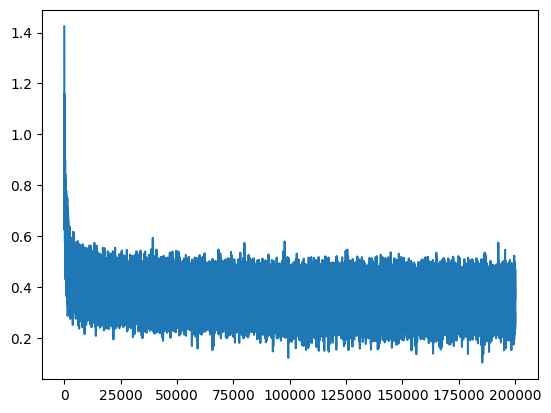

In [162]:
learn.fit(max_steps)
learn.plot_loss()
print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   

# Initialization tricks
## 1) Initializations of logits
## 2.1) Initializations of hidden states/activations
## 2.2) Initializations of hidden states/activations
## 3) Batch Normalization

## 1) Initializations of logits
Suppose we sample next char from an uniform distribution, then the log likelihood for each char is:
-log(1/n_classes) = -log(1/27) = 3.2958
    
So this is the value of log likelihood (i.e. of loss) from which we want to start (i.e. from an uniform distribution). \
Let's fit 1 batch -> very high loss (>> ~3.3)


This __wrong__ initialization is the reason of the "hockey stick" shape of the plot of the loss.


We must make all out logits be ~0.0 (or at least equal) such to start from the unif dist. High value of loss at start because the nn might randomly assign large values to logits that are not of the correct class in the last layer, so the nn is "very sure" about wrong things. 
For this reason the first iterations of optimization are "wasted" bcuz the nn is just correcting the random init.

0/1 loss: 26.297645568847656


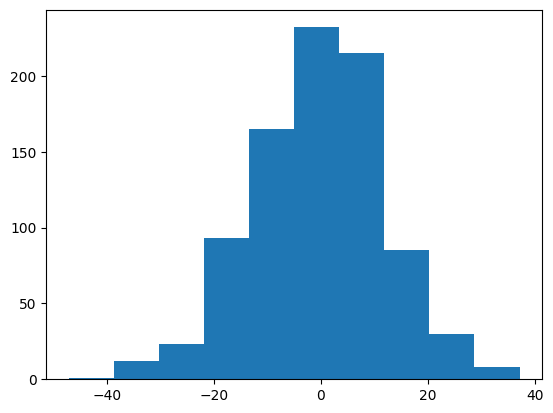

In [163]:
learn = Learner(bl)
learn.fit(1)
plt.hist(learn.logits.data.view(-1));

Logits have quite large range/scale: this is the issue that leads to very high loss in the beginning!
To fix this we can make w2 very small s.t. shrink down the logits close to 0. 

In [164]:
class Learner1(Learner):
    def init_W2(self): self.W2 = torch.randn((self.W1.shape[1], self.vocab_len)) *.01
    def init_b2(self): self.b2 = torch.zeros(self.vocab_len) 

0/1 loss: 3.2724428176879883


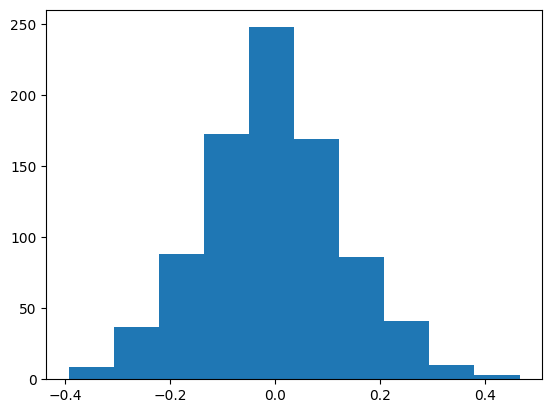

In [165]:
learn = Learner1(bl)
learn.fit(1)
plt.hist(learn.logits.data.view(-1));

0/200000 loss: 3.180776596069336
50000/200000 loss: 2.274890184402466
100000/200000 loss: 2.4674415588378906
150000/200000 loss: 2.9117445945739746
Loss on train: 2.1861424446105957
Loss on valid: 2.2541701793670654


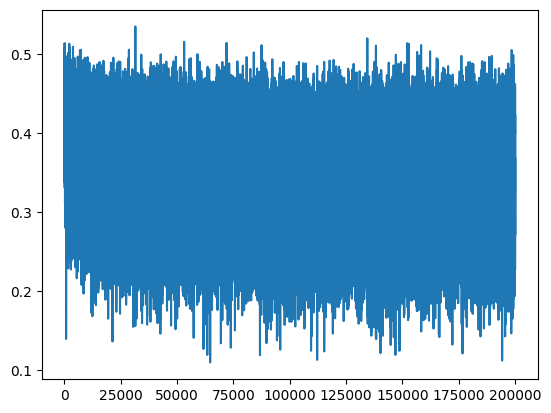

In [166]:
learn.fit(max_steps)
learn.plot_loss()
print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   

Now no hockey stick shape since we removed an useless part of the train in which the logits are just being fixed. Indeed we get a better result wrt the not logits init version:\
before we got: 2.24973 on val\
now we get:  2.238634 on val

## 2.1) Initializations of hidden states/activations

0/1 loss: 3.328859806060791


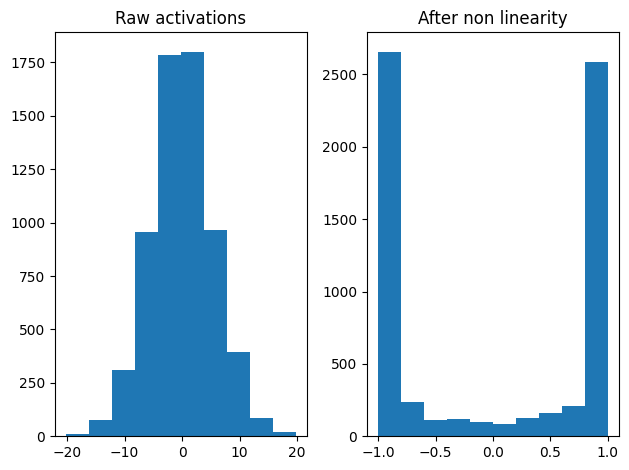

In [167]:
learn = Learner1(bl)
learn.fit(1)

plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.hist(learn.act.data.view(-1));
plt.title("Raw activations")

plt.subplot(1, 2, 2)
plt.hist(learn.h.data.view(-1));
plt.title("After non linearity")

plt.tight_layout()
plt.show()

Activations have large scales, this implies that after non-linearity (tanh here) the majority of values are in the -1, +1 bins.

If the value after non-linearity t=+/-1 then in the backward step the derivative of tanh: $(1-t**2)$ is 0. Bad: activations saturates the tanh in this layer -> neurons that output +/-1 at init will "activate" less frequently than others and thus will be updated less.

nb: tanh is a squashing funct both in forward and backward pass:
- during foward it clamps large values
- during backward it either: 
    - kills/diminishes grad if t~+/-1
    - all grad passes thru if t~0 

Always try to use act functs that do not have flat regions -> flat regions might lead to dead neurons, i.e. 
neurons that never activate -> never recieve gradient -> never learn

We need to fix W1 and b1 initialization s.t. after tanh we don't have many +/-1. This implies that we need to lower the scale of our activations by making W1/b1 small.

torch.Size([32, 200])

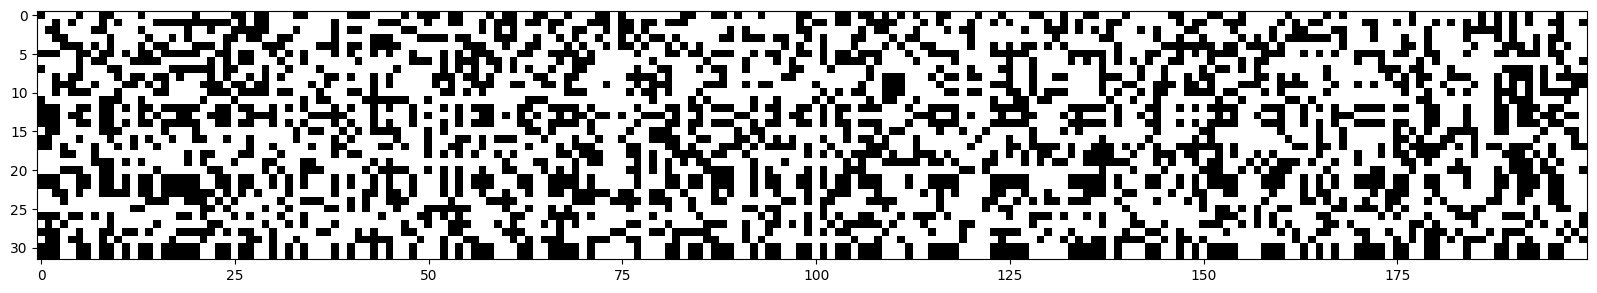

In [168]:
plt.figure(figsize=(20,10))
plt.imshow(learn.h.data.abs() >.99 , cmap='grey');
learn.h.data.shape

Another way to see/evaluate this is to use the plot above. 
Map of all activations that are greater then .99 for each neuron: 32 rows (each obs in batch) 100 cols (each neuron). If we have a whole white col it implies that we have a dead neuron that will never learn.

In [169]:
class Learner2(Learner1):    
    def init_W1(self): self.W1 = torch.randn((self.ctx_len * self.emb_size, self.hidden_shape)) *.2
    def init_b1(self): self.b1 = torch.randn(self.W1.shape[1]) *.01

0/1 loss: 3.2756521701812744


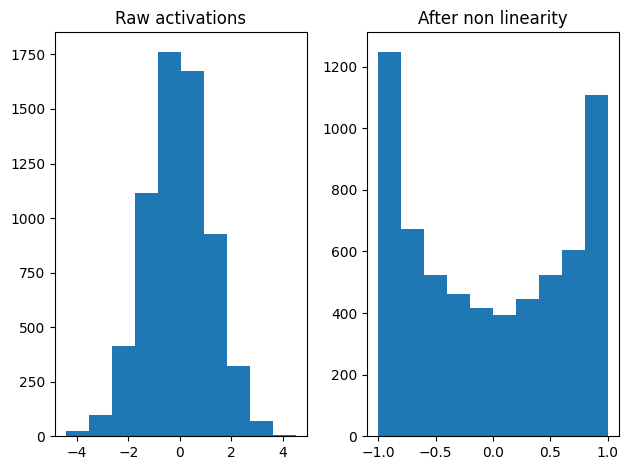

In [170]:
learn = Learner2(bl)
learn.fit(1)

plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.hist(learn.act.data.view(-1));
plt.title("Raw activations")

plt.subplot(1, 2, 2)
plt.hist(learn.h.data.view(-1));
plt.title("After non linearity")

plt.tight_layout()
plt.show()

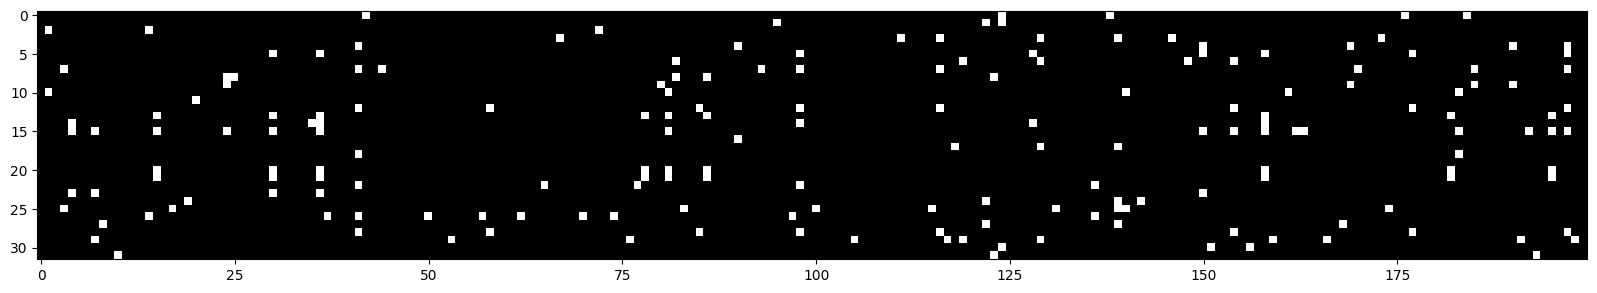

In [171]:
plt.figure(figsize=(20,10))
plt.imshow(learn.h.data.abs() >.99 , cmap='grey');
# IMPO: no full cols of white, but we should have some white

0/200000 loss: 3.2581894397735596
50000/200000 loss: 1.9844166040420532
100000/200000 loss: 2.321974277496338
150000/200000 loss: 2.29938006401062
Loss on train: 2.1341285705566406
Loss on valid: 2.186490297317505


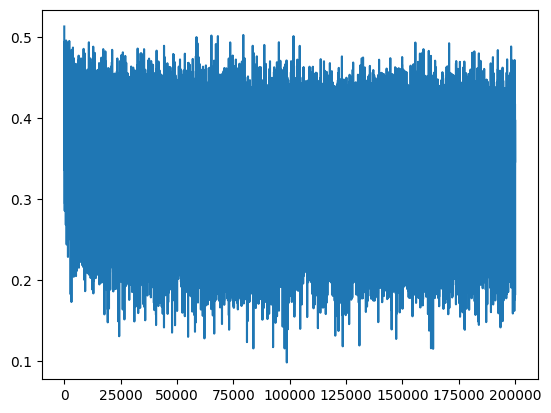

In [172]:
learn.fit(max_steps)
learn.plot_loss()
print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   

Improved result wrt the not h/acts init version: \
before we got: 2.238634 on val\
now we get: 2.182191 on val

## 2.2) Initializations of hidden states/activations
Symmetry and consistency in activations distribution across the different layers of the nn is important. 

The distribution of activations (pre non-linearity) for each layer should ~N(0,1). 

We can achieve this by scaling the weights W of each layer by a particular value computed wrt:
1) the act func used 
2) input dimensionality
   
The idea is that when you do: \
W @ X or W @ Hi \
you modify the variance (but same avg).\
Let's now consider a generic matrix multiplication of 2 matrices with values ~N(0,1):

In [173]:
test1 = torch.randn((1000,100))
print("Initial var:", test1.mean(), test1.std()**2)
test2 = test1 @ torch.randn((100,1000)) # matrices with values ~N(0,1)
print("Post @ mean, var:", test2.mean(), test2.std()**2)

Initial var: tensor(-0.0001) tensor(1.0080)
Post @ mean, var: tensor(0.0061) tensor(101.4728)


So even if you scale correctly each W to be ~N(0,1), then when the @ occurrs you still increas/decrease the var.
Thus we need to rescale w appropriately by sqrt(input dims).

In [174]:
test1 = torch.randn((1000,100)) / torch.tensor(100).sqrt()
print("Initial var:", test1.mean(), test1.std()**2)
test2 = test1 @ torch.randn((100,1000)) # matrices with values ~N(0,1)
print("Post @ mean, var:", test2.mean(), test2.std()**2)

Initial var: tensor(4.2474e-05) tensor(0.0100)
Post @ mean, var: tensor(0.0007) tensor(0.9954)


We also need to use some gain: the gain is used to scale the standard deviation with respect to the applied non-linearity.
Since the non-linearity will affect the std dev of the activation, you might run into some issues, e.g. vanishing gradients. The gain with respect to the non-linearity should give you “good” statistics of your activations.
What happens is that these gains are "computed" such to fight the clamping/squashing power of the non-linear functions that are applied layer after layer: if we do not compensate with gains > 1 then our activations post non linearity will collapse -> bad training because we don't have symmetry and consistency in activations distribution across the different layers of the nn. If we apply this gain the variance stabilizes layer after layer. 
nb we will also see this in a plot in:

In [175]:
test2.tanh().mean(), test2.tanh().std()**2

(tensor(0.0006), tensor(0.3922))

In [176]:
test1 = torch.randn((1000,100)) / torch.tensor(100).sqrt()
test2 = test1 @ torch.randn((100,1000)) # matrices with values ~N(0,1)
test2 *= torch.nn.init.calculate_gain('tanh') # = 5/3
test2.tanh().mean(), test2.tanh().std()

(tensor(0.0007), tensor(0.7587))

In [177]:
class Learner3(Learner1):    
    def init_W1(self):    
        kaiming_init = torch.nn.init.calculate_gain('tanh') / torch.tensor(self.ctx_len * self.emb_size).sqrt()
        self.W1 = torch.randn((self.ctx_len * self.emb_size, self.hidden_shape)) * kaiming_init        
    def init_b1(self): self.b1 = torch.randn(self.W1.shape[1]) *.01

0/200000 loss: 3.3401427268981934
50000/200000 loss: 2.209296703338623
100000/200000 loss: 2.134044647216797
150000/200000 loss: 2.091951847076416
Loss on train: 2.137439727783203
Loss on valid: 2.1927008628845215


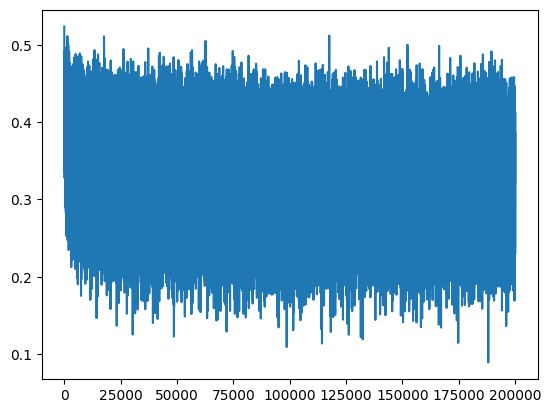

In [178]:
learn = Learner3(bl)
learn.fit(max_steps)
learn.plot_loss()
print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   

# Barch Norm
You don't want pre-activations of the tanh to be:
- too large cuz tanh out goes to flat region (i.e. saturates)
- too small cuz tanh not active. 

So we might use BN in layers with multiplications.
The idea of batch norm is to normalize the pre-activations not only at init but also across the training

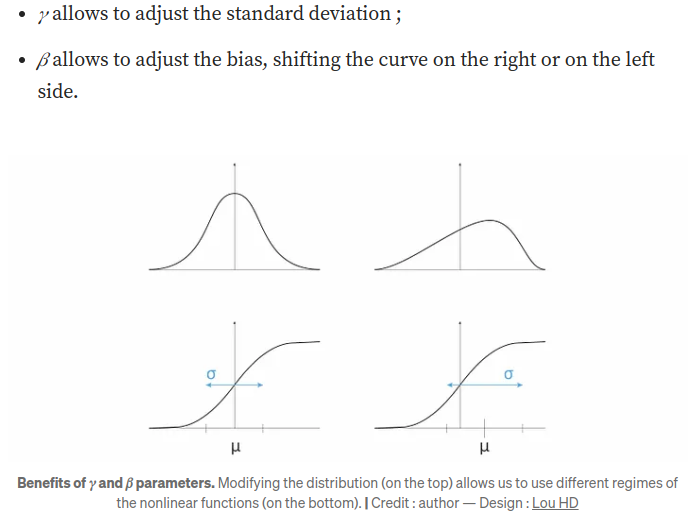

In [179]:
display.Image("/home/marconobile/Desktop/karpathy/bn.png")
# https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338#b93c

In [180]:
class LearnerBN(Learner3):    
    
    def __init__(self, batch_loader, momentum=.01):
        super().__init__(batch_loader)
        self.momentum = momentum
    
    def init(self):
        '''Do not use bias for layer before BN layer'''
        self.init_C()
        self.init_W1()
        # do not use b1 self.init_b1()
        self.init_W2()
        self.init_b2()
        
        # ~N(0, 1) at init
        self.bn_gain = torch.ones((1, self.hidden_shape)) # scale of pre-activations dist 
        self.bn_bias = torch.zeros((1, self.hidden_shape)) # shift of pre-activations dist 
        
        self.params = [self.C, self.W1, self.W2, self.b2, self.bn_gain, self.bn_bias]
        for p in self.params: p.requires_grad = True  
        
    def fit(self, steps):

        self.bn_mean_running = torch.zeros(1, self.hidden_shape)
        self.bn_std_running = torch.ones(1, self.hidden_shape)        
        self.losses, self.iter = [], []
        for self.i in range(steps):
            xb, yb = self.batch_loader()            
            emb = self.C[xb]
            emb_cat = emb.view(-1, self.ctx_len * self.emb_size)
            self.act = emb_cat @ self.W1 # no +b1 shift operation cuz BN centers (i.e. removes b1)             
            
            # batch norm 
            batch_mean = self.act.mean(dim=0, keepdim=True) 
            # collapse over the rows (i.e. take the mean of all the obs for each neuron <-dim=0)
            batch_std = self.act.std(dim=0, keepdim=True)
            self.act = self.bn_gain * (self.act - batch_mean)/(batch_std + 1e-5) + self.bn_bias             
            
            self.h = torch.tanh(self.act) 
            self.logits = self.h @ self.W2 + self.b2                 
            loss = F.cross_entropy(self.logits, yb)            
            for p in self.params: p.grad = None                
            loss.backward()            
            self.update_lr()
            for p in self.params: p.data += - self.lr * p.grad    
            self.losses.append(loss.log10().item())
            self.iter.append(self.i)
            if self.i % 50000 == 0: print(f'{self.i}/{steps} loss: {loss.item()}')
                
            with torch.no_grad():
                # if bs large -> low momentum ok, else better small
                # here bs = 32 (quite small) so we should have 0.001 
                self.bn_mean_running = (1 - self.momentum) * self.bn_mean_running + self.momentum * batch_mean
                self.bn_std_running = (1 - self.momentum) * self.bn_std_running + self.momentum * batch_std    
                
    @torch.no_grad()
    def evaluate_split_loss(self, x, y):
        emb = self.C[x]
        emb_cat = emb.view(-1, self.ctx_len * self.emb_size)
        self.act = emb_cat @ self.W1 # no +b1 shift operation cuz BN centers (i.e. removes b1)             

        # batch norm 
        self.act = self.bn_gain * (self.act - self.bn_mean_running)/(self.bn_std_running + 1e-5) + self.bn_bias             
        self.h = torch.tanh(self.act) 
        
        self.logits = self.h @ self.W2 + self.b2     
        return  F.cross_entropy(self.logits, y)

0/200000 loss: 3.3413071632385254
50000/200000 loss: 2.0541772842407227
100000/200000 loss: 2.403563976287842
150000/200000 loss: 1.8789105415344238
Loss on train: 2.137951612472534
Loss on valid: 2.1753859519958496


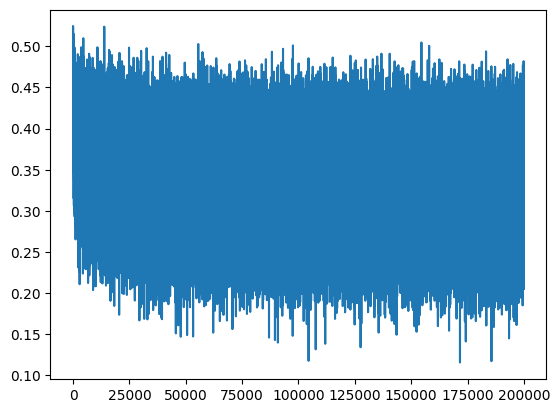

In [181]:
learn = LearnerBN(bl)
learn.fit(max_steps)
learn.plot_loss()
print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   

# Do not use BN since it couples obs over different batches

There is an issue with BN: it relies on computing the mean and standard deviation estimates across mini-batches. So other normalization techniques are used: 
- layer norm* (more common)
- instance norm
- group norm* (more common)

# Visualizations
## 1) Visualization of activations
## 2) Visualization of gradients
## 3) Visualization of weights and grads
## 4) Visualization params updates

In [182]:
class Linear:    
    def __init__(self, inp_dims, out_dims, bias=True):
        self.weight = torch.randn((inp_dims, out_dims)) / inp_dims**.5
        self.bias = torch.zeros(out_dims) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    
    def parameters(self): return [self.weight] + ([] if self.bias is None else [self.bias])

In [183]:
class BatchNorm1d:    
    def __init__(self, dims, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # bn params
        self.gamma = torch.ones(dims)
        self.beta = torch.zeros(dims)
        # buffers
        self.running_mean = torch.zeros(dims)
        self.running_var = torch.ones(dims)
        
        
    def __call__(self, x):
        if self.training: # use batch stats
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else: # use running stats stats
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self): return [self.gamma, self.beta]

In [184]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self): return []

In [276]:
class Learner:
    def __init__(self, batch_loader, gain, lr=.1, ctx_len=3, emb_size=10, hidden_shape=100):
        self.batch_loader, self.lr, self.gain = batch_loader, lr, gain        
        self.ctx_len, self.emb_size, self.hidden_shape = ctx_len, emb_size, hidden_shape
        self.vocab_len = 27
        
        self.C = torch.randn(self.vocab_len, self.emb_size)
        self.layers = [
            Linear(self.ctx_len*self.emb_size, self.hidden_shape),
            Linear(self.hidden_shape, self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.vocab_len)
        ]

        with torch.no_grad():
            self.layers[-1].weight *= .1 # make last layer logits dist uniform
            for layer in self.layers:
                if isinstance(layer, Linear): layer.weight *= self.gain

        self.parameters = [self.C] + [p for layer in self.layers for p in layer.parameters()]
        for p in self.parameters: p.requires_grad = True
            
    def update_lr(self): self.lr = self.lr if self.i < 100000 else .01

    def fit_batch(self, x):
        emb = self.C[x]
        emb_cat = emb.view(-1, self.ctx_len * self.emb_size)
        self.act = emb_cat @ self.W1 + self.b1
        self.h = torch.tanh(self.act) 
        self.logits = self.h @ self.W2 + self.b2     
                
    def fit(self, steps):    
        self.update = []
        for self.i in range(steps):

            xb, yb = self.batch_loader()
            emb = self.C[xb] 
            x = emb.view(emb.shape[0], -1)
            for layer in self.layers: x = layer(x)
            loss = F.cross_entropy(x, yb)

            # retain grads for visualization purposes
            for layer in self.layers: layer.out.retain_grad() 
            for p in self.parameters: p.grad = None

            loss.backward()
            self.update_lr()
            for p in self.parameters: p.data += - self.lr * p.grad   
            
            with torch.no_grad():
                self.update.append([(self.lr* p.grad.std()/p.data.std()).log10().item() for p in self.parameters])
                # log10 allows us to evaluate wrt the exponents/ order of magnitude

    def plot_activations(self):    
        plt.figure(figsize=(20, 4))
        legends = []
        for i, layer in enumerate(self.layers[:-1]):
            if isinstance(layer, Tanh):
                t = layer.out
                print(f'{layer.__class__.__name__} {i}: mean: {t.mean():.3f}, std: {t.std():.3f}, saturated: {(t.abs() > .97).float().mean()*100}%')
                hy, hx = torch.histogram(t, density = True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'Tanh {i}')
        plt.legend(legends)
        plt.title('activation distribution')
        
    def plot_gradients(self):
        plt.figure(figsize=(20, 4))
        legends = []
        for i, layer in enumerate(self.layers[:-1]):
            if isinstance(layer, Tanh):
                t = layer.out.grad
                print(f'{layer.__class__.__name__} {i}: mean: {t.mean()}, std: {t.std()}')
                hy, hx = torch.histogram(t, density = True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'Tanh {i}')
        plt.legend(legends)
        plt.title('Gradients distribution')
        
    def plot_weights_grads(self):
        plt.figure(figsize=(20, 4))
        legends = []
        for i, p in enumerate(self.parameters):
            t = p.grad
            if p.ndim == 2:
                print(f'weight {i}: {p.shape}: mean: {t.mean():.5}, std: {t.std():.5}, grad/data {t.std()/p.std():.5}')        
                hy, hx = torch.histogram(t, density = True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'weight {i}: {p.shape}')
        plt.legend(legends)
        plt.title('Weights and gradients distribution')
        
    def plot_params_updates(self):
        plt.figure(figsize=(20, 4))
        legends = []
        for i, p in enumerate(self.parameters):
            if p.ndim == 2:
                plt.plot([self.update[j][i] for j in range(len(self.update))])
                legends.append(f'weight {i}: {p.shape}')
        plt.plot([0, len(self.update)], [-3, -3], 'k') # guide/target ~ 1e-3
        plt.legend(legends)
        plt.title('weights and Gradients distribution')

## 1) Visualization of activations
### 1.1) gain = 1
Analysis of activations before tanh (no out layer, logits do not need to follow the following criterias)

Tanh 2: mean: -0.023, std: 0.627, saturated: 3.84375%
Tanh 4: mean: 0.023, std: 0.497, saturated: 0.09375%
Tanh 6: mean: -0.019, std: 0.417, saturated: 0.0%
Tanh 8: mean: 0.014, std: 0.375, saturated: 0.0%


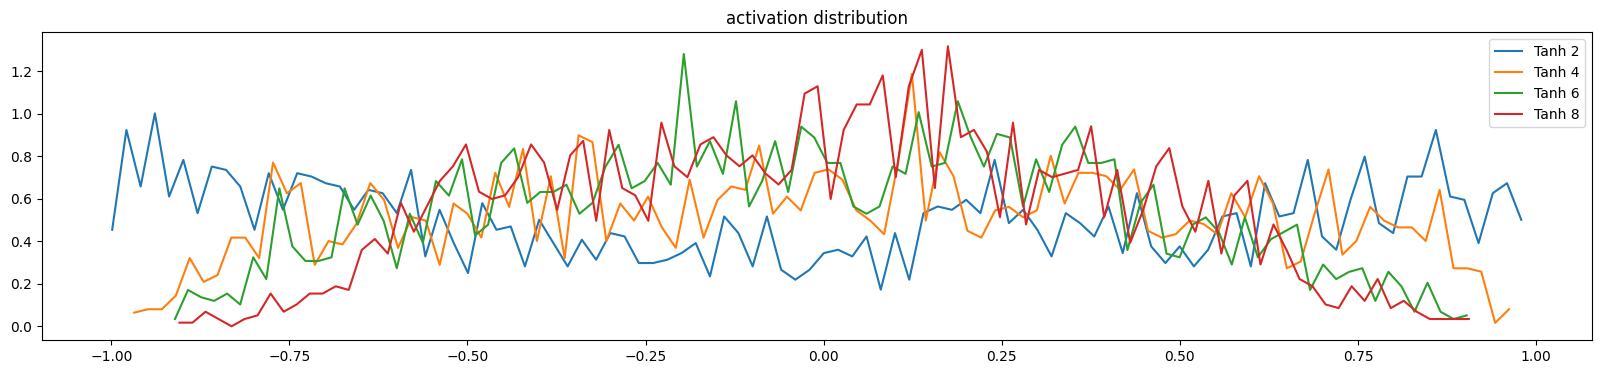

In [277]:
learn = Learner(bl, gain=1)
learn.fit(1)
learn.plot_activations()

### 1.2) gain = 10

Tanh 2: mean: -0.002, std: 0.996, saturated: 98.28125%
Tanh 4: mean: -0.008, std: 0.961, saturated: 84.25%
Tanh 6: mean: -0.020, std: 0.957, saturated: 83.59375%
Tanh 8: mean: -0.022, std: 0.954, saturated: 80.9375%


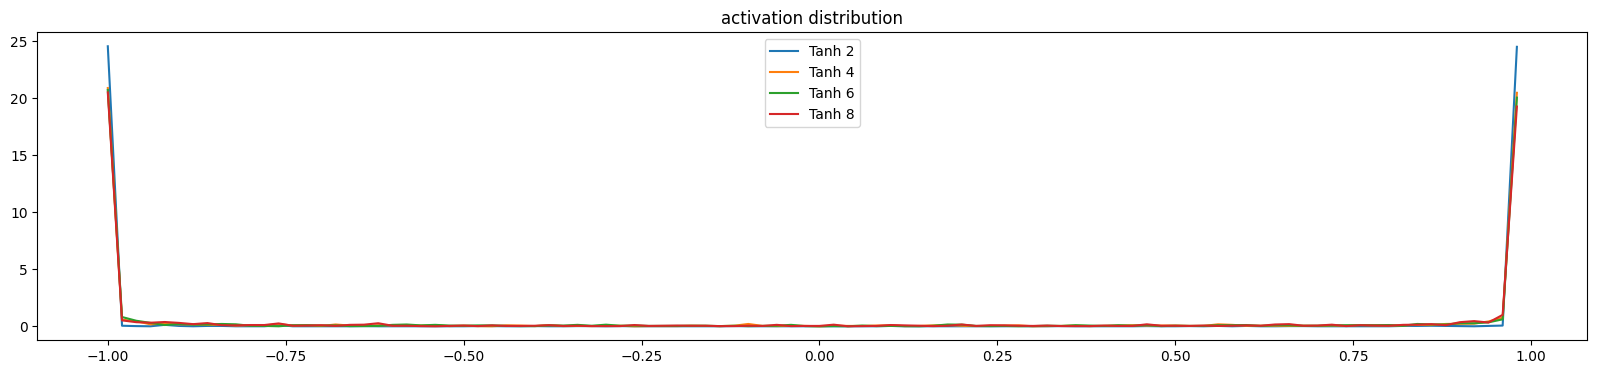

In [278]:
learn = Learner(bl, gain=10)
learn.fit(1)
learn.plot_activations()

If we use gain=1 (instead of 5/3 as precomputed for the tanh), what happens is that the first layer is okay, but then, given that the tanh is a squashing func, the activations get recursively squashed -> an expanding/appropriate gain is requested to fight against this squashings.

As the values show the std shrinks, and saturation collapses to 0. 

Too large eg gain=10 just leads to high value of saturation and thus higher probability of dead neurons. Saturation of 5% is okay/good/desired

### 1.3) gain = tanh gain

Tanh 2: mean: -0.024, std: 0.860, saturated: 45.71875%
Tanh 4: mean: -0.009, std: 0.741, saturated: 15.1875%
Tanh 6: mean: -0.030, std: 0.689, saturated: 9.34375%
Tanh 8: mean: -0.004, std: 0.655, saturated: 6.687500476837158%


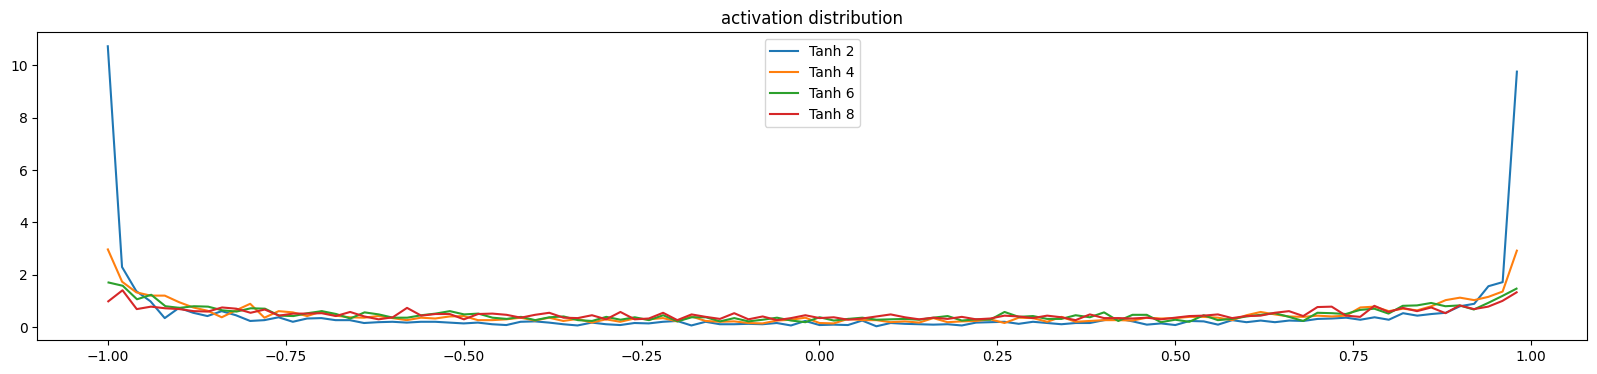

In [279]:
learn = Learner(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_activations()

If we use gain=5/3 as precomputed for the tanh, what happens is that all layers are very similar, and layer after layer std and saturation stabilize insted of collapsing/exploding.

## 2) Visualization of gradients

### 2.1) gain = too low

Tanh 2: mean: -1.9513609572641144e-07, std: 1.8344524505664594e-05
Tanh 4: mean: -8.925830456973927e-07, std: 3.7806497857673094e-05
Tanh 6: mean: 3.083417595917126e-06, std: 7.821233884897083e-05
Tanh 8: mean: 2.1112773538334295e-06, std: 0.00015365617582574487


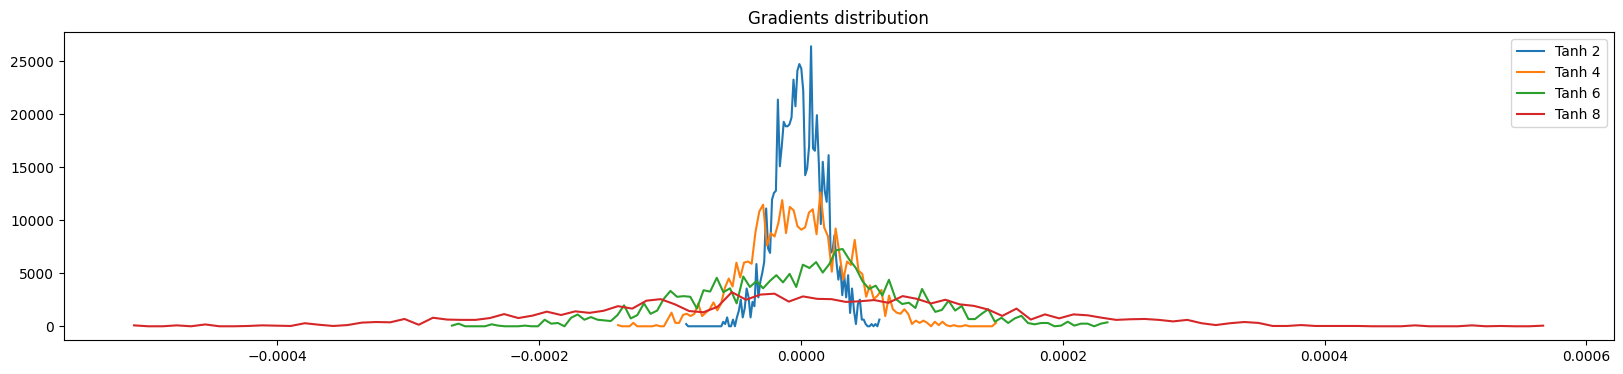

In [280]:
learn = Learner(bl, gain=.5)
learn.fit(1)
learn.plot_gradients()

### 2.2) gain = too large

Tanh 2: mean: 0.0005044848658144474, std: 0.03532179072499275
Tanh 4: mean: -0.0001945444237207994, std: 0.014805259183049202
Tanh 6: mean: 0.0001897584443213418, std: 0.007079950533807278
Tanh 8: mean: -0.0001890774437924847, std: 0.0032092458568513393


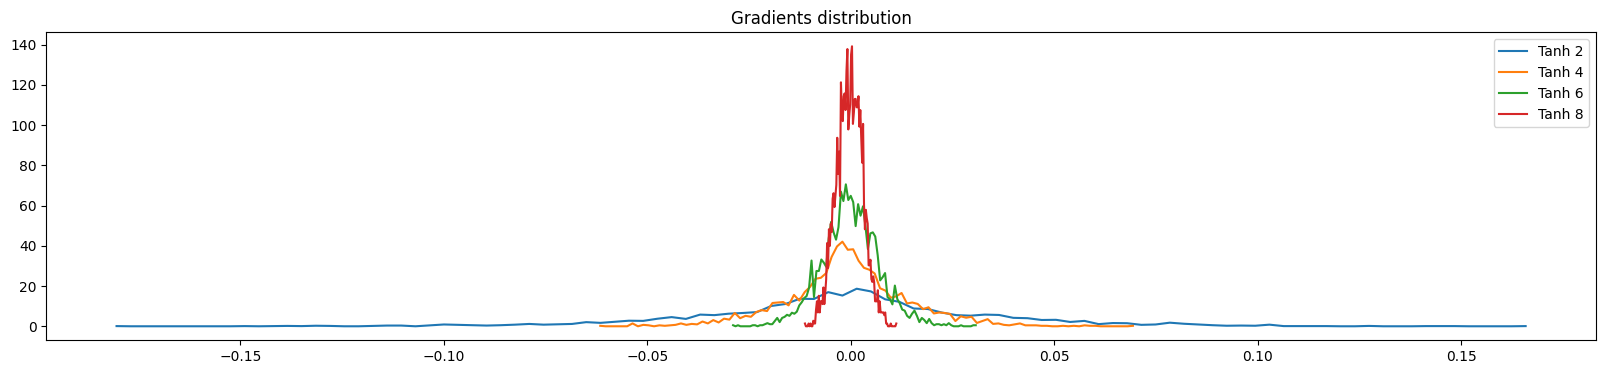

In [281]:
learn = Learner(bl, gain=10)
learn.fit(1)
learn.plot_gradients()

In the plots above we can see the behavior of the gradients when the gain/init is wrong. The gradients explode across the different layers, but what we actually want is to have grads that behave in the same manner i.e. they must not shrink/explode. With gain .5 we can see that the grad distributions flatten out -> increase variance, whereas with gain = 10 they explode

### 2.3) gain = tanh gain

Tanh 2: mean: -5.281804078549612e-06, std: 0.0006047317292541265
Tanh 4: mean: 8.825360055197962e-06, std: 0.0005901955300942063
Tanh 6: mean: -2.7335458071320318e-05, std: 0.0005394119070842862
Tanh 8: mean: -2.034058161370922e-05, std: 0.0005165333859622478


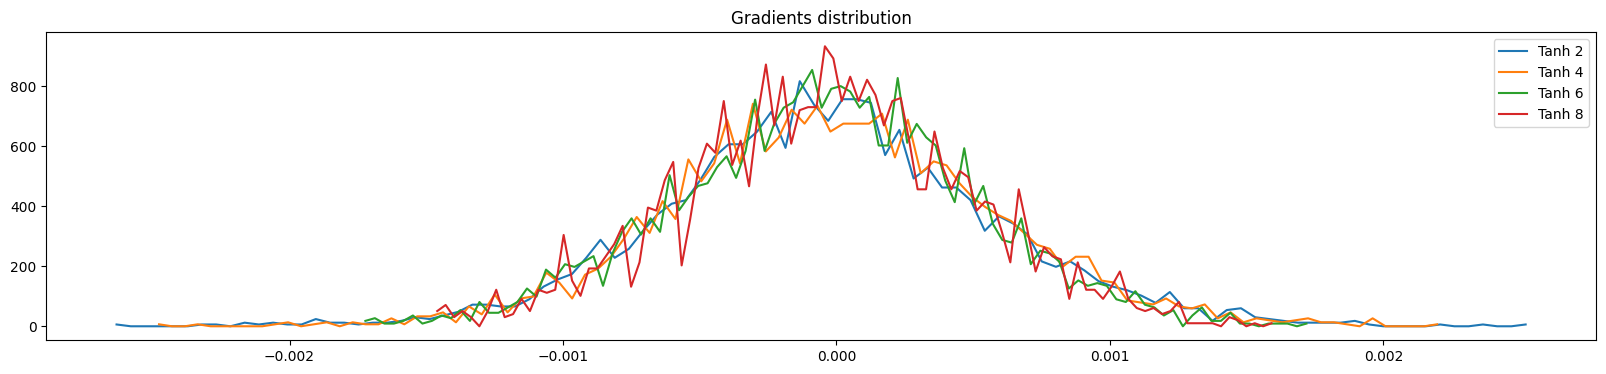

In [282]:
learn = Learner(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_gradients()

With the right gain all good. The gradients of all the different layers must behave in the same manner i.e. they must not shrink/explode.

### CORE IDEA:
you want symmetry and consistency across the whole nn.

Activations and the gradients of the network must behave in the same manner across all the depth of the network! 

You don't want the activations distributions to shrink/flatten-out, nor that the gradient behave in a different 
way by shrink/flatten-out over the different layers.
You achieve this using the correct initialization:
- the kaiming init
- adam
- residual connections

If our init is fkd up we can see that we have large % of saturation or very spiked/asymmetric gradients
and the update to params are very spread vertically -> each layer is training at its own speed

## 3) Visualization of weights and grads

weight 0: torch.Size([27, 10]): mean: 0.00015471, std: 0.0021461, grad/data 0.0018293
weight 1: torch.Size([30, 100]): mean: -1.828e-05, std: 0.0026614, grad/data 0.0087223
weight 3: torch.Size([100, 100]): mean: -7.1465e-06, std: 0.0029083, grad/data 0.017429
weight 5: torch.Size([100, 100]): mean: 1.3969e-05, std: 0.0018303, grad/data 0.01094
weight 7: torch.Size([100, 100]): mean: -1.2367e-05, std: 0.001558, grad/data 0.0092398
weight 9: torch.Size([100, 100]): mean: 2.6265e-06, std: 0.0012993, grad/data 0.0078584
weight 11: torch.Size([100, 27]): mean: 4.6911e-11, std: 0.022227, grad/data 1.3269


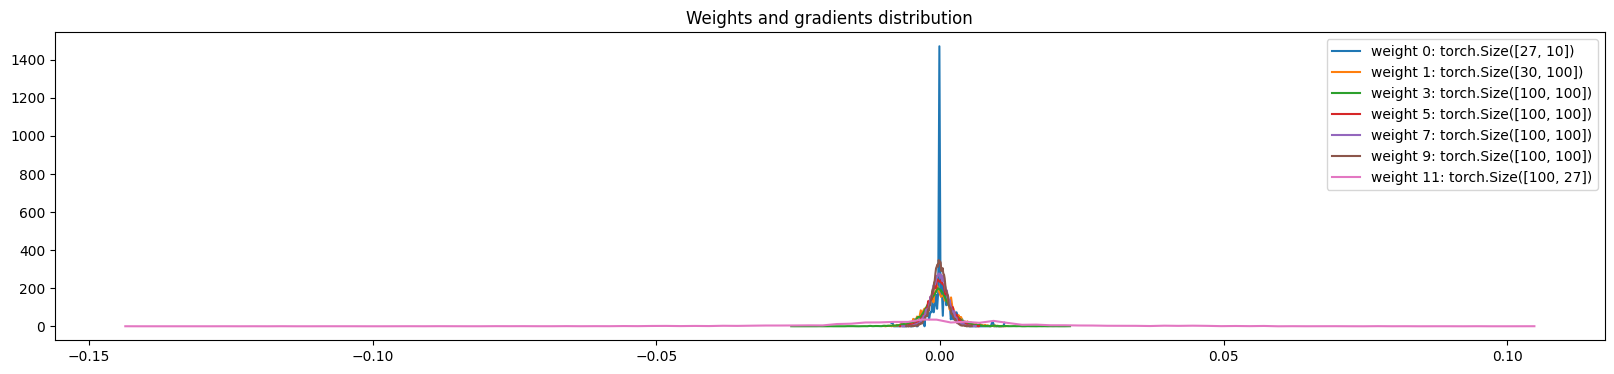

In [283]:
learn = Learner(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_weights_grads()

In the plot above we are seeing: 
- mean of the gradient of a W
- std of the gradient of a W
- the ratio: grad/data of a W

The last give an idea of the scale of grad wrt scale of the actual values.
If grad is too large wrt scale of data is bad. 
We have that the scale of weights wrt their grads is okay for all layers except the last where its grads are way bigger that the scale of its parameter; this means that we are training the last layer way faster then the others, and again this asymmetry is bad! all std of other layers are in the order of 1e-3, the last layer is in the order of 1e-2 thus it is trained 10x faster then the other layers

weight 0: torch.Size([27, 10]): mean: -2.6836e-05, std: 0.0084629, grad/data 0.0072165
weight 1: torch.Size([30, 100]): mean: 0.00016549, std: 0.0084293, grad/data 0.027495
weight 3: torch.Size([100, 100]): mean: -1.7445e-05, std: 0.0085505, grad/data 0.050368
weight 5: torch.Size([100, 100]): mean: -2.1565e-05, std: 0.006701, grad/data 0.039636
weight 7: torch.Size([100, 100]): mean: -5.149e-05, std: 0.0057684, grad/data 0.033937
weight 9: torch.Size([100, 100]): mean: -3.2036e-05, std: 0.0046999, grad/data 0.02829
weight 11: torch.Size([100, 27]): mean: 5.5189e-12, std: 0.021111, grad/data 0.30256


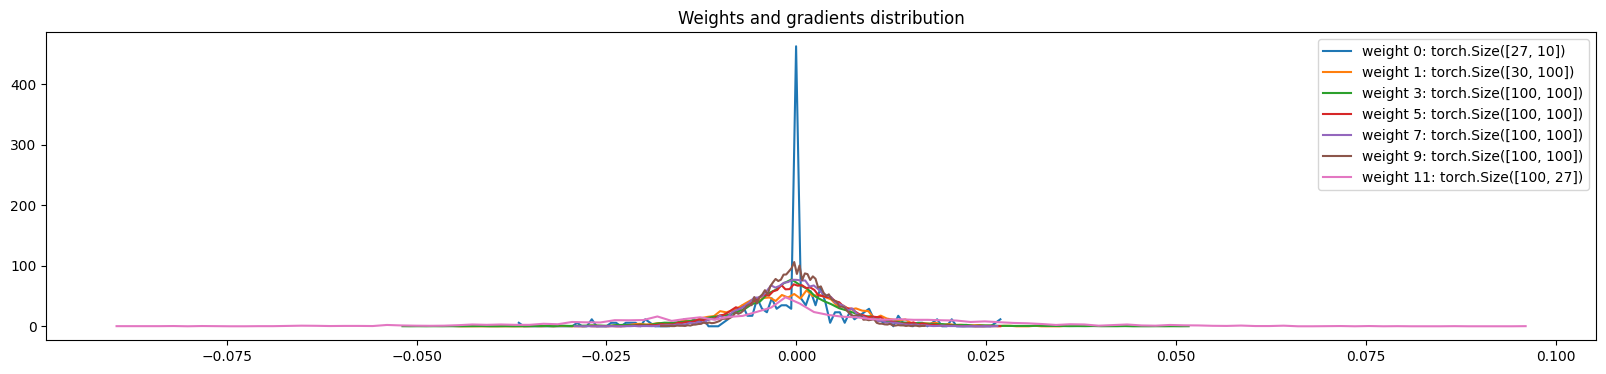

In [284]:
learn.fit(1000)
learn.plot_weights_grads()

Even after 1000 iterations the problem is not fixed.

## 4) Visualization params updates

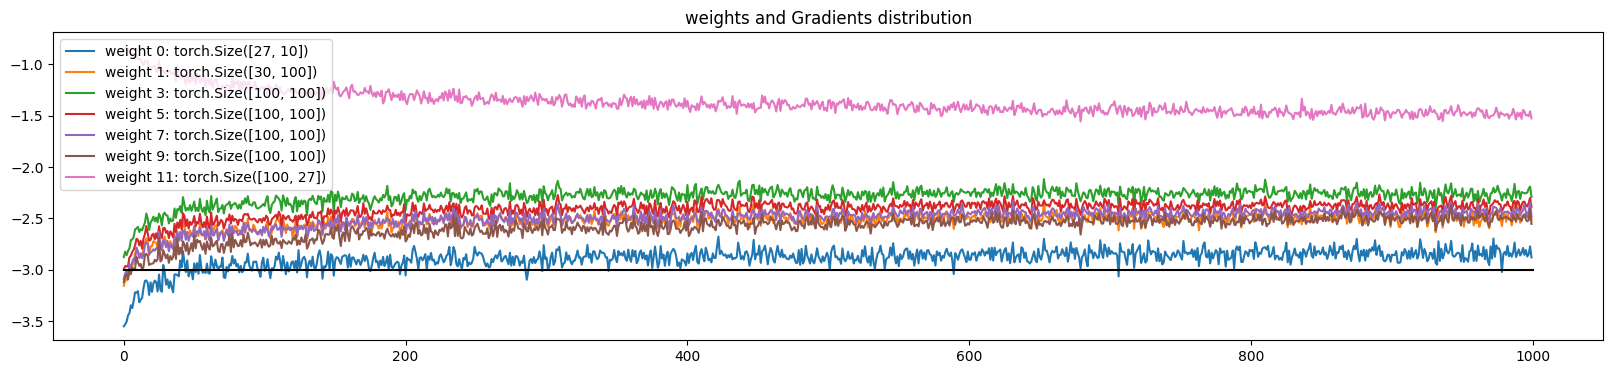

In [285]:
learn = Learner(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1000)
learn.plot_params_updates()

In [286]:
torch.tensor(1e-3).log10().item() # updates scale

-3.0

If the updates are below -3.0 (1e-3 if not in log10 scale) it means that params are not being update fast enough.
The lines/updates-trends should not be far from -3. 
The last layer is an outlier cuz we scaled it down s.t. make logits behave as an uniform dist and thus since its values are smallers it acts as if it is learning faster (its grads/weights ratio is larger cuz weights have been shrunk down). Indeed if our lr is too small then we have the following: (indeed in the pic above we can see that we have a slighly too large lr). The idea here is that the updates to the weighs should be not greater then 1e-3 of the params values.

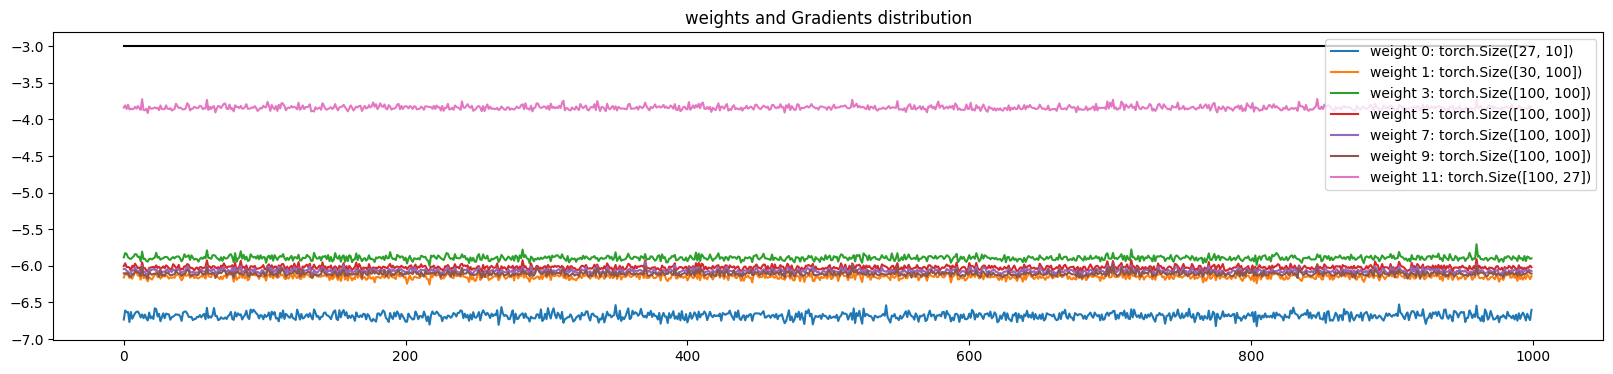

In [287]:
learn = Learner(bl, gain=torch.nn.init.calculate_gain('tanh'), lr=0.0001)
learn.fit(1000)
learn.plot_params_updates()

## Some bad examples:

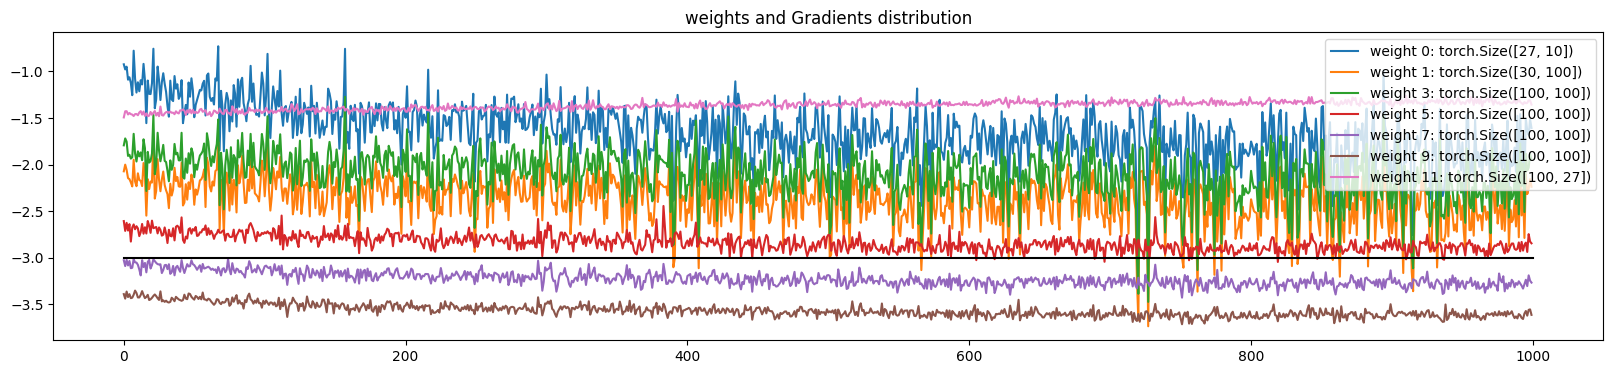

In [288]:
learn = Learner(bl, gain=10)
learn.fit(1000)
learn.plot_params_updates()

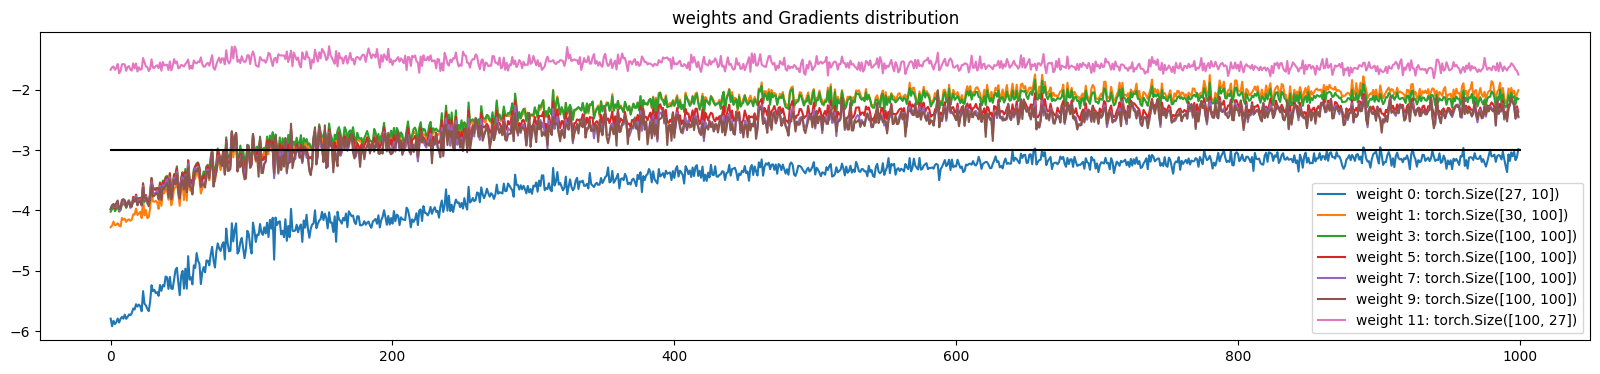

In [289]:
learn = Learner(bl, gain=.5)
learn.fit(1000)
learn.plot_params_updates()

## Test for better lr:

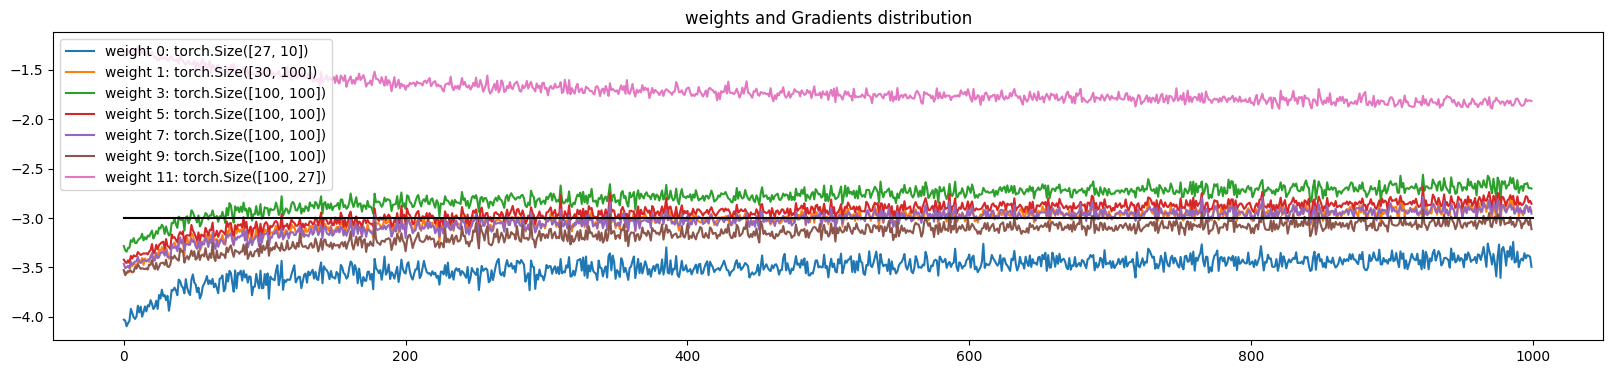

In [290]:
learn = Learner(bl, gain=torch.nn.init.calculate_gain('tanh'), lr=0.035)
learn.fit(1000)
learn.plot_params_updates()

# Let's now insert the BatchNorm1d and see how it fixes stuff

In [291]:
class LearnerBN(Learner):
    def __init__(self, batch_loader, gain, lr=.1, ctx_len=3, emb_size=10, hidden_shape=100):
        self.batch_loader, self.lr, self.gain = batch_loader, lr, gain        
        self.ctx_len, self.emb_size, self.hidden_shape = ctx_len, emb_size, hidden_shape
        self.vocab_len = 27
        
        self.C = torch.randn(self.vocab_len, self.emb_size)
        self.layers = [
            Linear(self.ctx_len*self.emb_size, self.hidden_shape),
            Linear(self.hidden_shape, self.hidden_shape), BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.hidden_shape), BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.hidden_shape), BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.hidden_shape), BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.vocab_len), BatchNorm1d(self.vocab_len)
#             Linear(self.hidden_shape, self.vocab_len) # also fine
        ]

        with torch.no_grad():
#             self.layers[-1].weight *= .1 # make last layer logits dist uniform
            self.layers[-1].gamma *= .1 # if last layer is BatchNorm1d
            for layer in self.layers:
                if isinstance(layer, Linear): layer.weight *= self.gain

        self.parameters = [self.C] + [p for layer in self.layers for p in layer.parameters()]
        for p in self.parameters: p.requires_grad = True

Tanh 3: mean: 0.002, std: 0.629, saturated: 3.21875%
Tanh 6: mean: -0.002, std: 0.636, saturated: 2.34375%
Tanh 9: mean: -0.000, std: 0.640, saturated: 2.65625%
Tanh 12: mean: -0.001, std: 0.639, saturated: 2.25%


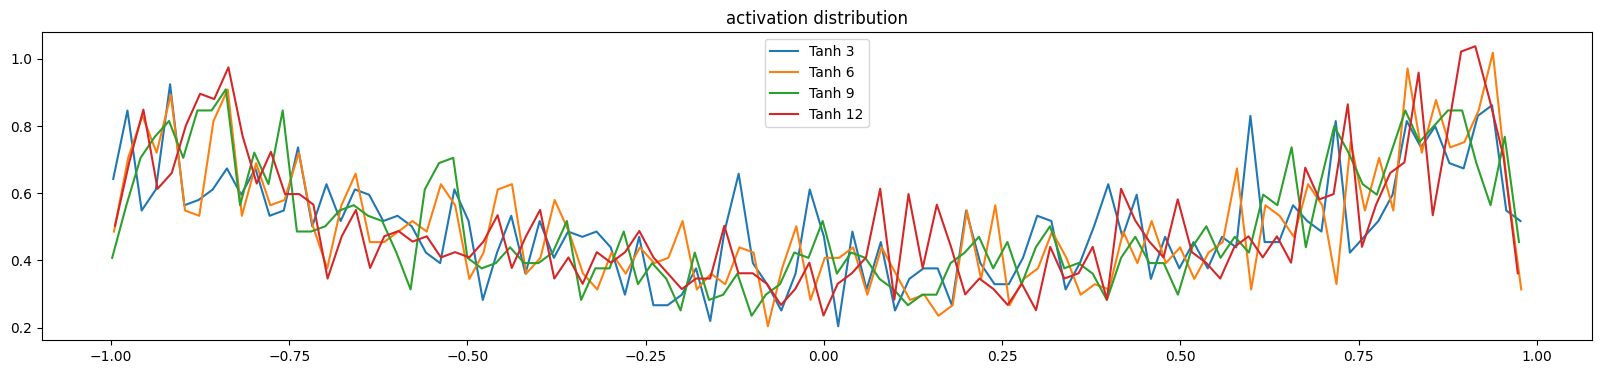

In [292]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_activations()

Tanh 3: mean: -1.4551915445207286e-12, std: 0.0007226514280773699
Tanh 6: mean: 2.9103830890414573e-12, std: 0.0006129308603703976
Tanh 9: mean: 2.9103830890414573e-12, std: 0.0005534251104108989
Tanh 12: mean: -1.164153192248496e-12, std: 0.0005047971499152482


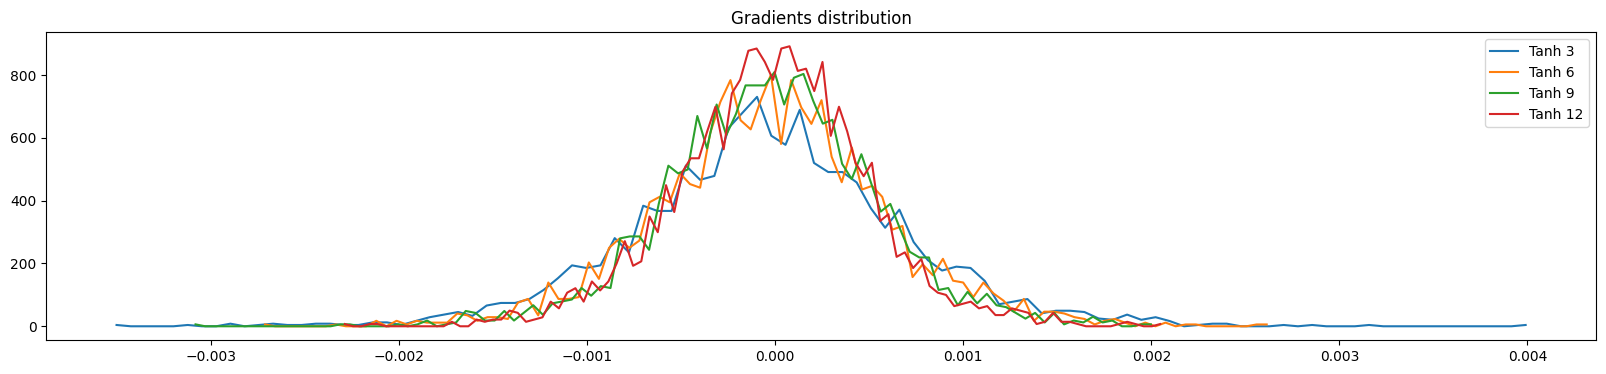

In [295]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_gradients()

weight 0: torch.Size([27, 10]): mean: -1.3797e-11, std: 0.0015802, grad/data 0.0015653
weight 1: torch.Size([30, 100]): mean: 2.4703e-05, std: 0.0019566, grad/data 0.0063361
weight 3: torch.Size([100, 100]): mean: -4.8317e-06, std: 0.0021611, grad/data 0.012922
weight 7: torch.Size([100, 100]): mean: 2.9111e-05, std: 0.0018815, grad/data 0.01126
weight 11: torch.Size([100, 100]): mean: 8.6872e-06, std: 0.0019168, grad/data 0.011526
weight 15: torch.Size([100, 100]): mean: 9.5904e-06, std: 0.0017662, grad/data 0.010556
weight 19: torch.Size([100, 27]): mean: 3.1427e-05, std: 0.0027642, grad/data 0.016736


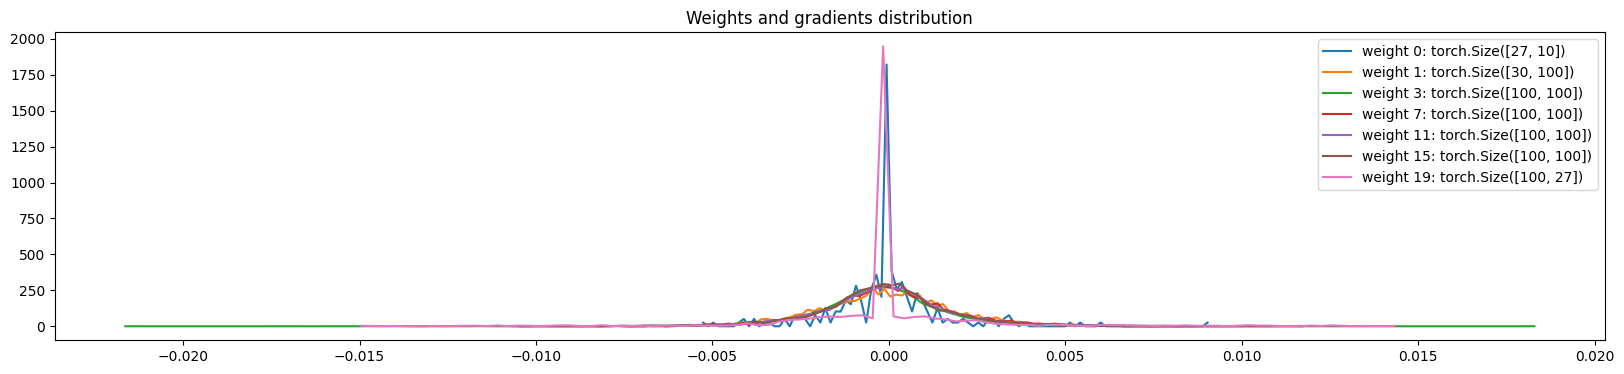

In [296]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_weights_grads()

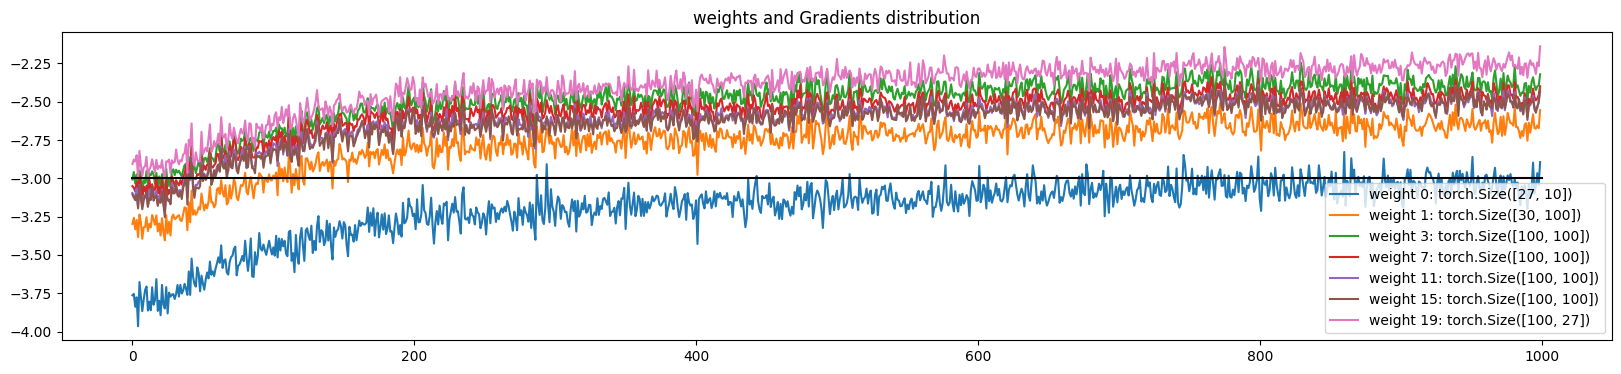

In [297]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1000)
learn.plot_params_updates()

With BN we are more robust in general wrt inits, only thing make sure to fix lr.
Always try to find the bottleneck of the model.

# Exercises:
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [298]:
class Linear:    
    def __init__(self, inp_dims, out_dims, bias=True):
        self.weight = torch.zeros((inp_dims, out_dims))
        self.bias = torch.zeros(out_dims) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    
    def parameters(self): return [self.weight] + ([] if self.bias is None else [self.bias])

Tanh 3: mean: 0.000, std: 0.000, saturated: 0.0%
Tanh 6: mean: 0.000, std: 0.000, saturated: 0.0%
Tanh 9: mean: 0.000, std: 0.000, saturated: 0.0%
Tanh 12: mean: 0.000, std: 0.000, saturated: 0.0%


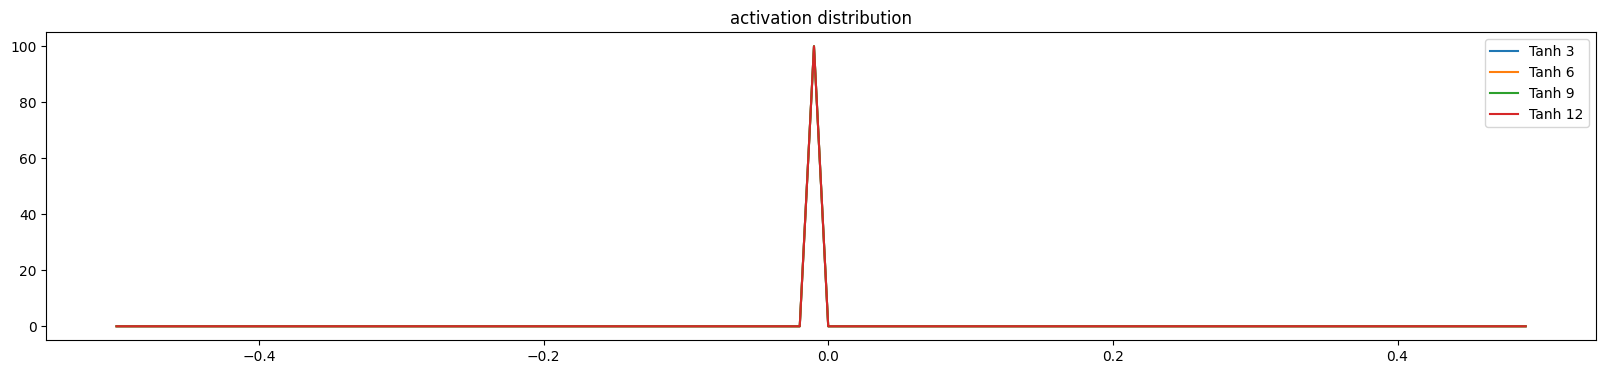

In [299]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_activations()

Tanh 3: mean: 0.0, std: 0.0
Tanh 6: mean: 0.0, std: 0.0
Tanh 9: mean: 0.0, std: 0.0
Tanh 12: mean: 0.0, std: 0.0


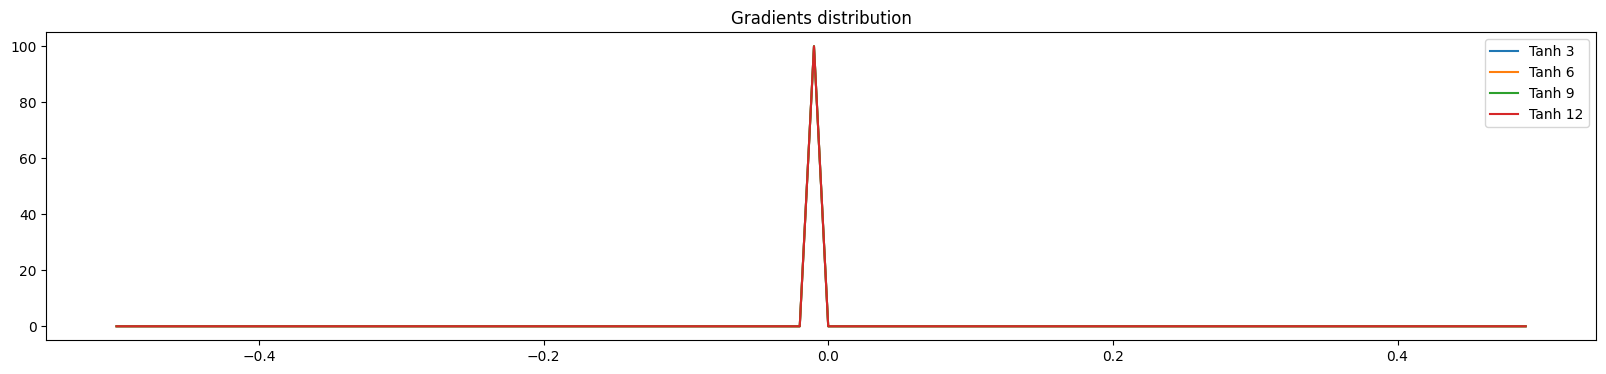

In [300]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_gradients()

weight 0: torch.Size([27, 10]): mean: 0.0, std: 0.0, grad/data 0.0
weight 1: torch.Size([30, 100]): mean: 0.0, std: 0.0, grad/data nan
weight 3: torch.Size([100, 100]): mean: 0.0, std: 0.0, grad/data nan
weight 7: torch.Size([100, 100]): mean: 0.0, std: 0.0, grad/data nan
weight 11: torch.Size([100, 100]): mean: 0.0, std: 0.0, grad/data nan
weight 15: torch.Size([100, 100]): mean: 0.0, std: 0.0, grad/data nan
weight 19: torch.Size([100, 27]): mean: 0.0, std: 0.0, grad/data nan


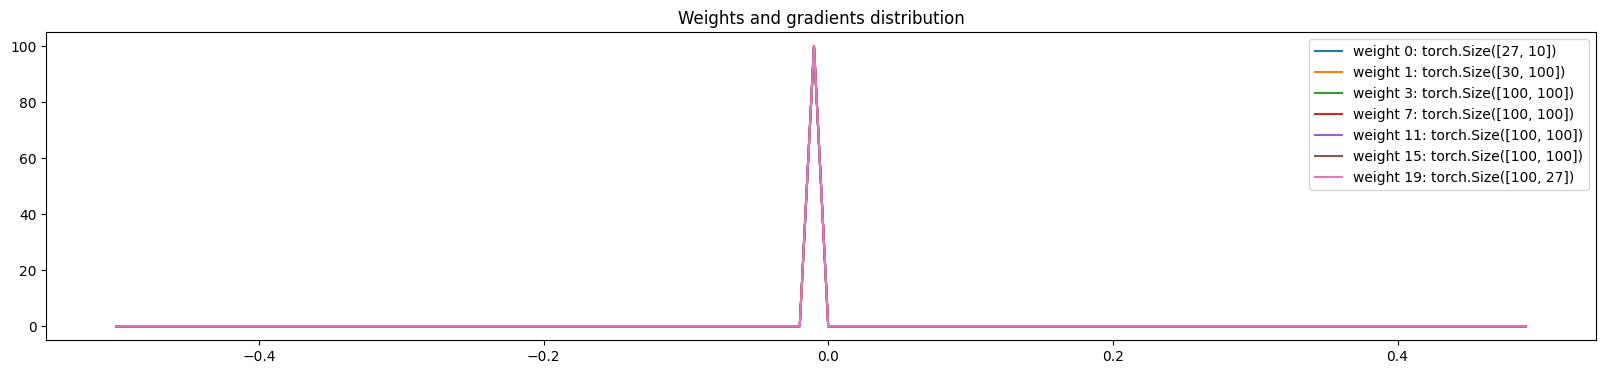

In [301]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1)
learn.plot_weights_grads()

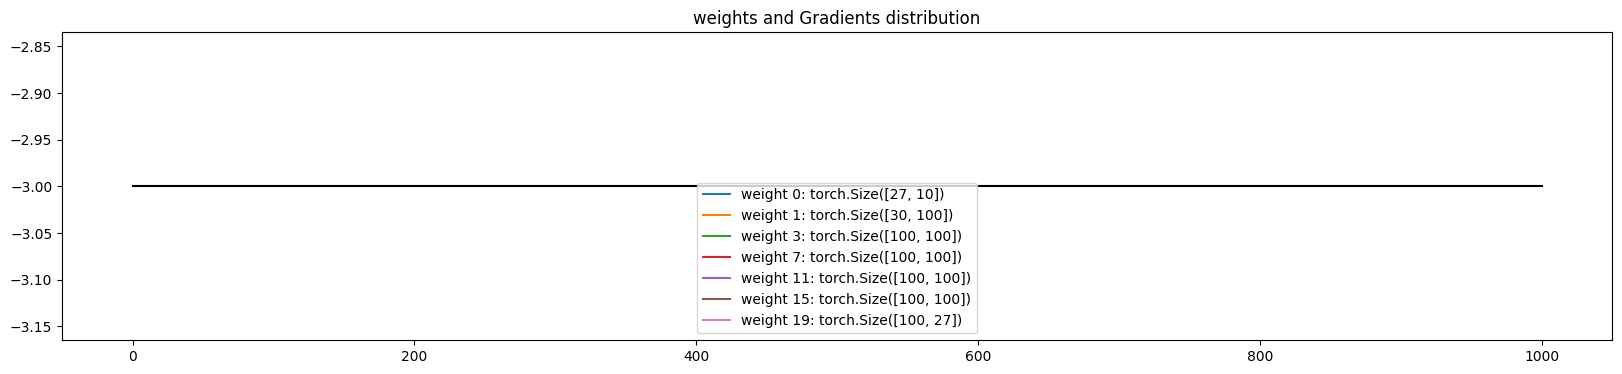

In [302]:
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
learn.fit(1000)
learn.plot_params_updates()